In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from langdetect import detect, DetectorFactory
from collections import Counter

In [2]:
input = '../data/data_intermediaire_train.parquet'

In [3]:
df = pd.read_parquet(input)
df

,text,label
0,The Sea Is Watching has been made from an orig...,1
1,There are so many reasons as to why I rate the...,1
2,The documentary presents an original theory ab...,1
3,Of all Arnold's mid-'80s movies who would have...,1
4,This Was One Scary Movie.<br /><br />Brad Pitt...,1
...,...,...
24995,This may be one of the worst movies to ever ma...,0
24996,This is certainly the worst movie i ever saw? ...,0
24997,for all the subtle charms this student film ma...,0
24998,Let's be honest shall we? Al Gore no more TRUL...,0


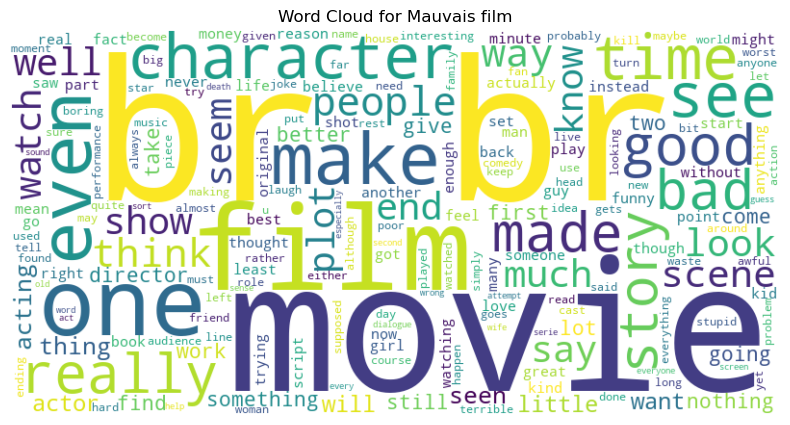

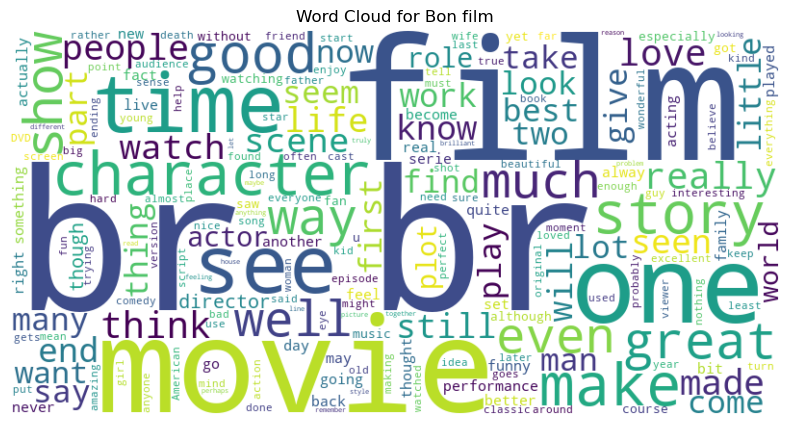

In [4]:
# Charger les données
file_path = '../data/data_intermediaire_train.parquet'
df = pd.read_parquet(file_path)

# Ajouter des stopwords supplémentaires si nécessaire
additional_stopwords = set(["the", "a", "an", "and", "is", "it", "of", "to", "in", "this", "that", "with"])
stopwords = STOPWORDS.union(additional_stopwords)

# Créer un nuage de mots pour chaque catégorie (0: mauvais film, 1: bon film)
for label, category in [(0, "Mauvais film"), (1, "Bon film")]:
    # Filtrer les données pour la catégorie actuelle
    category_data = df[df['label'] == label]['text'].str.cat(sep=' ')

    # Générer le nuage de mots
    wordcloud = WordCloud(stopwords=stopwords, background_color='white', width=800, height=400).generate(category_data)

    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {category}")
    plt.show()


In [ ]:
nltk.download('punkt')

DetectorFactory.seed = 0  
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

df['language'] = df['text'].apply(detect_language)

language_counts = df['language'].value_counts()
print("Distribution des langues détectées :")
print(language_counts)


Statistiques sur le nombre de mots :
count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: word_count, dtype: float64


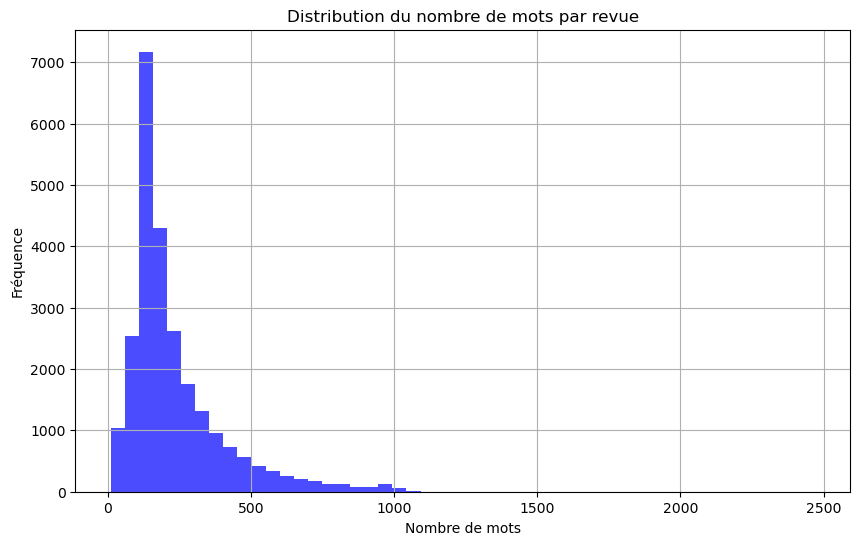

In [ ]:
def count_words(text):
    if isinstance(text, str):  
        words = text.split()  
        return len(words)
    return 0

# Ajouter une colonne pour le nombre de mots
df['word_count'] = df['text'].apply(count_words)

# Statistiques sur le nombre de mots
word_count_distribution = df['word_count'].describe()
print("\nStatistiques sur le nombre de mots :")
print(word_count_distribution)

# Visualisation de la distribution du nombre de mots
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution du nombre de mots par revue')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()